# EDA-1: Statistical Exploratory Data Analysis

Comprehensive statistical analysis of the XJTU-SY bearing dataset across:
- 3 operating conditions (35Hz/12kN, 37.5Hz/11kN, 40Hz/10kN)
- 15 bearings (5 per condition)
- 9,216 files total
- 65 extracted features (37 time-domain + 28 frequency-domain)

## Key Analysis Areas
1. Dataset imbalance analysis
2. Feature distributions across conditions
3. Feature distributions across bearings
4. Horizontal vs vertical channel comparison
5. Cross-channel correlation analysis
6. Degradation progression tracking (RMS, kurtosis trends)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Load feature dataset
df = pd.read_csv('../outputs/features/features_v2.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()[:10]}...")

Dataset shape: (9216, 71)

Columns: ['condition', 'bearing_id', 'filename', 'file_idx', 'total_files', 'rul', 'h_mean', 'h_std', 'h_variance', 'h_rms']...


## 1. Dataset Overview and Imbalance Analysis

The XJTU-SY dataset has known imbalance - the 40Hz/10kN condition contains significantly more data due to longer bearing run times.

In [3]:
# Dataset overview
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns) - 6} (excluding metadata)")
print(f"\nConditions: {df['condition'].unique().tolist()}")
print(f"Bearings: {df['bearing_id'].nunique()}")

DATASET OVERVIEW
Total samples: 9,216
Total features: 65 (excluding metadata)

Conditions: ['35Hz12kN', '37.5Hz11kN', '40Hz10kN']
Bearings: 15



Samples per Condition:
----------------------------------------
  35Hz12kN: 616 (6.7%)
  37.5Hz11kN: 1,566 (17.0%)
  40Hz10kN: 7,034 (76.3%)


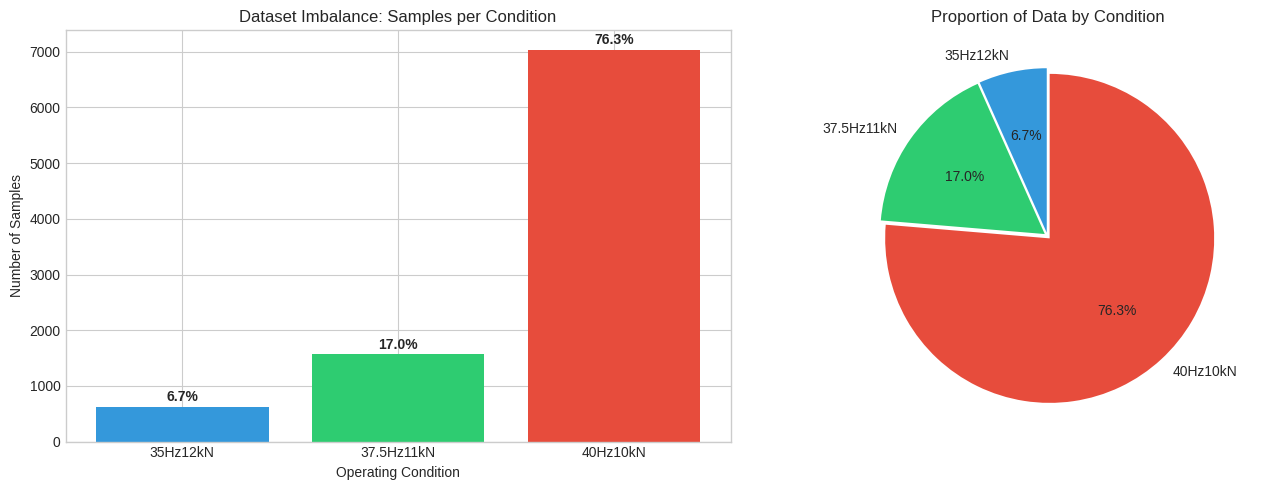


⚠️  IMBALANCE NOTE: 40Hz10kN contains 76.3% of all data


In [4]:
# Samples per condition
condition_counts = df['condition'].value_counts().sort_index()
condition_pct = (condition_counts / len(df) * 100).round(1)

print("\nSamples per Condition:")
print("-" * 40)
for cond in condition_counts.index:
    print(f"  {cond}: {condition_counts[cond]:,} ({condition_pct[cond]}%)")

# Visualize imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#3498db', '#2ecc71', '#e74c3c']
ax = axes[0]
bars = ax.bar(condition_counts.index, condition_counts.values, color=colors)
ax.set_xlabel('Operating Condition')
ax.set_ylabel('Number of Samples')
ax.set_title('Dataset Imbalance: Samples per Condition')
for bar, pct in zip(bars, condition_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{pct}%', ha='center', va='bottom', fontweight='bold')

# Pie chart
ax = axes[1]
ax.pie(condition_counts.values, labels=condition_counts.index, autopct='%1.1f%%',
       colors=colors, explode=[0.02, 0.02, 0.02], startangle=90)
ax.set_title('Proportion of Data by Condition')

plt.tight_layout()
plt.show()

print(f"\n⚠️  IMBALANCE NOTE: 40Hz10kN contains {condition_pct['40Hz10kN']}% of all data")

In [5]:
# Samples per bearing
bearing_counts = df.groupby(['condition', 'bearing_id']).size().reset_index(name='count')
bearing_counts = bearing_counts.pivot(index='bearing_id', columns='condition', values='count').fillna(0)

print("\nSamples per Bearing:")
print("-" * 60)

# Create a detailed breakdown table
bearing_summary = df.groupby(['condition', 'bearing_id']).agg({
    'filename': 'count',
    'total_files': 'first'
}).reset_index()
bearing_summary.columns = ['Condition', 'Bearing', 'Files', 'Total Files']

print(bearing_summary.to_string(index=False))


Samples per Bearing:
------------------------------------------------------------
 Condition    Bearing  Files  Total Files
  35Hz12kN Bearing1_1    123          123
  35Hz12kN Bearing1_2    161          161
  35Hz12kN Bearing1_3    158          158
  35Hz12kN Bearing1_4    122          122
  35Hz12kN Bearing1_5     52           52
37.5Hz11kN Bearing2_1    491          491
37.5Hz11kN Bearing2_2    161          161
37.5Hz11kN Bearing2_3    533          533
37.5Hz11kN Bearing2_4     42           42
37.5Hz11kN Bearing2_5    339          339
  40Hz10kN Bearing3_1   2538         2538
  40Hz10kN Bearing3_2   2496         2496
  40Hz10kN Bearing3_3    371          371
  40Hz10kN Bearing3_4   1515         1515
  40Hz10kN Bearing3_5    114          114


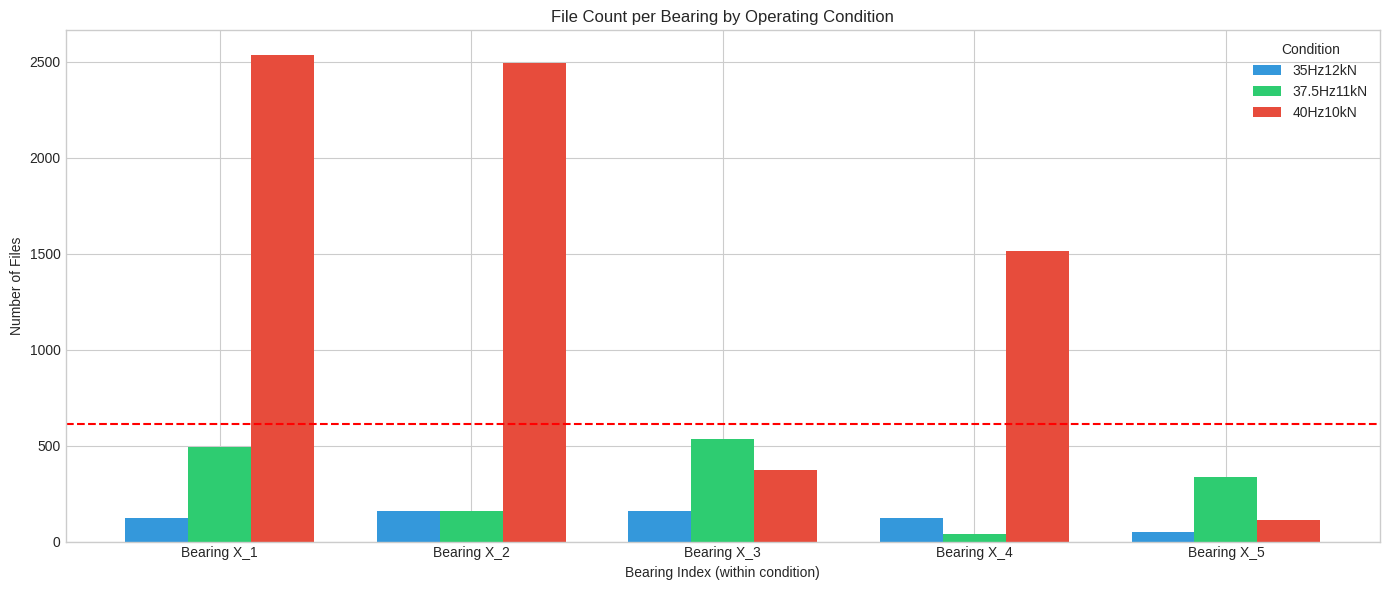

In [6]:
# Visualize bearing file counts by condition
fig, ax = plt.subplots(figsize=(14, 6))

conditions = ['35Hz12kN', '37.5Hz11kN', '40Hz10kN']
x = np.arange(5)  # 5 bearings per condition
width = 0.25

for i, cond in enumerate(conditions):
    cond_data = df[df['condition'] == cond].groupby('bearing_id')['filename'].count()
    # Sort by bearing number
    cond_data = cond_data.sort_index()
    ax.bar(x + i * width, cond_data.values, width, label=cond, color=colors[i])

ax.set_xlabel('Bearing Index (within condition)')
ax.set_ylabel('Number of Files')
ax.set_title('File Count per Bearing by Operating Condition')
ax.set_xticks(x + width)
ax.set_xticklabels(['Bearing X_1', 'Bearing X_2', 'Bearing X_3', 'Bearing X_4', 'Bearing X_5'])
ax.legend(title='Condition')
ax.axhline(y=df.groupby('bearing_id')['filename'].count().mean(), 
           color='red', linestyle='--', label='Mean')

plt.tight_layout()
plt.show()

## 2. Feature Distributions Across Conditions

Analyze how key health indicator features vary across the three operating conditions.

In [7]:
# Key features for analysis
key_features = [
    'h_rms', 'v_rms',           # Root Mean Square - amplitude indicator
    'h_kurtosis', 'v_kurtosis', # Kurtosis - impulsiveness indicator
    'h_std', 'v_std',           # Standard deviation - variability
    'h_crest_factor', 'v_crest_factor',  # Peak/RMS ratio
    'h_spectral_centroid', 'v_spectral_centroid',  # Frequency content
]

# Summary statistics by condition
print("Key Feature Statistics by Condition:")
print("=" * 80)
condition_stats = df.groupby('condition')[key_features].agg(['mean', 'std', 'median'])
print(condition_stats.round(4).T)

Key Feature Statistics by Condition:
condition                    35Hz12kN  37.5Hz11kN   40Hz10kN
h_rms               mean       1.4457      1.6421     0.8978
                    std        1.3123      1.9075     0.8261
                    median     0.7879      0.5723     0.5139
v_rms               mean       1.6610      1.8780     0.9874
                    std        1.6794      1.9875     1.0734
                    median     0.7554      0.8498     0.6482
h_kurtosis          mean       0.9845      0.3582     0.2130
                    std        5.7322      0.6091     0.4136
                    median     0.4729      0.0522     0.0870
v_kurtosis          mean       0.1328      0.2011     0.3787
                    std        1.0223      0.5114     0.6727
                    median     0.0463      0.0260     0.0449
h_std               mean       1.4449      1.6417     0.8974
                    std        1.3129      1.9077     0.8261
                    median     0.7870      0.571

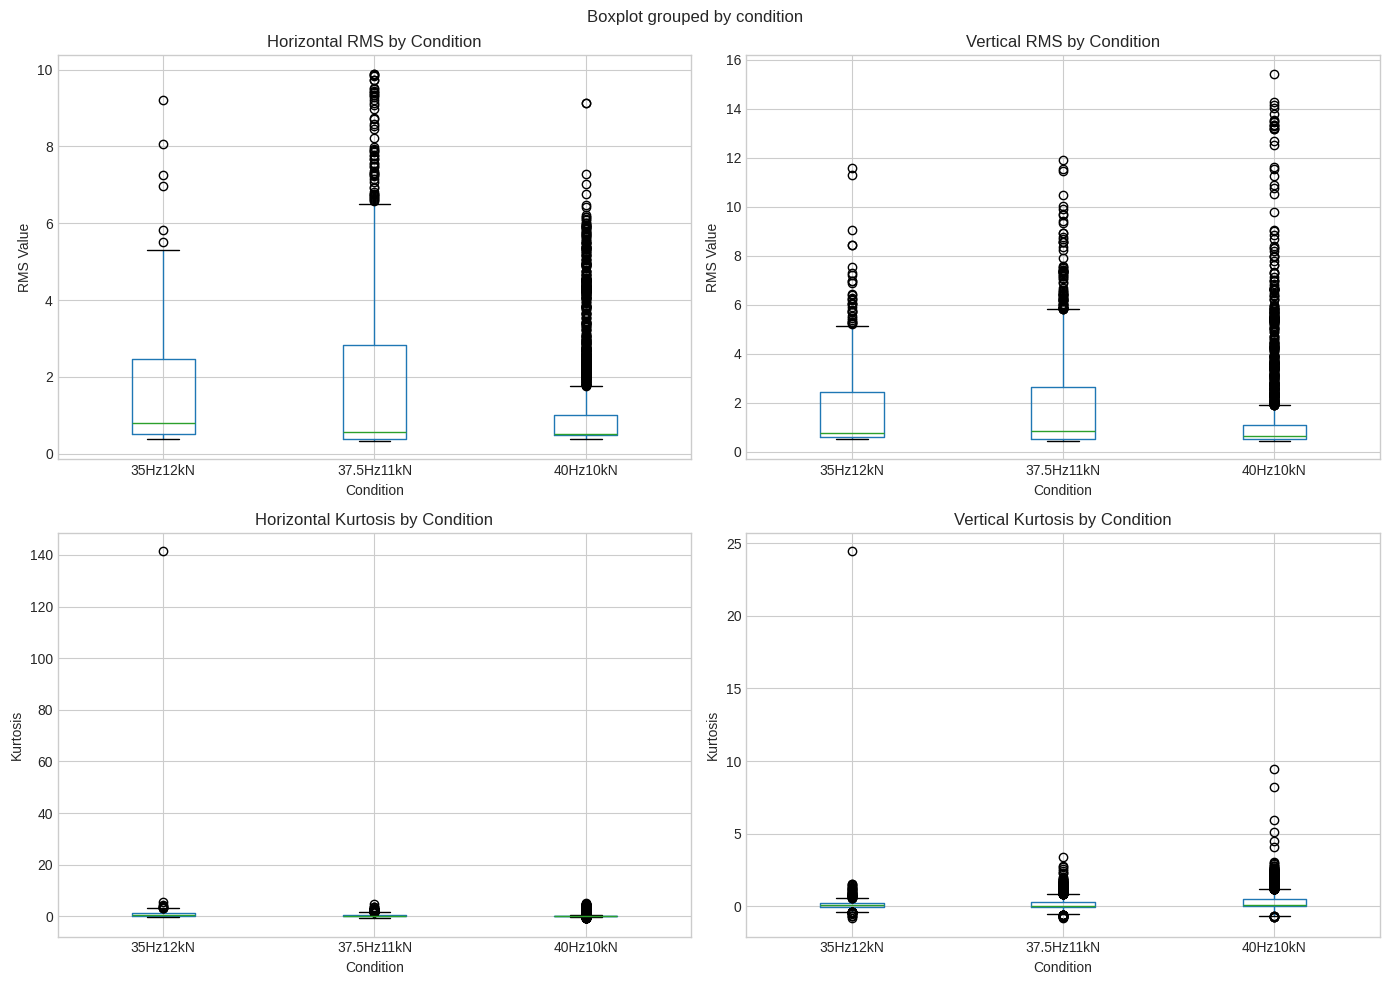

In [8]:
# Box plots for RMS distribution by condition
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMS - Horizontal
ax = axes[0, 0]
df.boxplot(column='h_rms', by='condition', ax=ax)
ax.set_title('Horizontal RMS by Condition')
ax.set_xlabel('Condition')
ax.set_ylabel('RMS Value')
plt.suptitle('')

# RMS - Vertical
ax = axes[0, 1]
df.boxplot(column='v_rms', by='condition', ax=ax)
ax.set_title('Vertical RMS by Condition')
ax.set_xlabel('Condition')
ax.set_ylabel('RMS Value')

# Kurtosis - Horizontal
ax = axes[1, 0]
df.boxplot(column='h_kurtosis', by='condition', ax=ax)
ax.set_title('Horizontal Kurtosis by Condition')
ax.set_xlabel('Condition')
ax.set_ylabel('Kurtosis')

# Kurtosis - Vertical
ax = axes[1, 1]
df.boxplot(column='v_kurtosis', by='condition', ax=ax)
ax.set_title('Vertical Kurtosis by Condition')
ax.set_xlabel('Condition')
ax.set_ylabel('Kurtosis')

plt.tight_layout()
plt.show()

/tmp/ipykernel_343828/1250122280.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='condition', y=feat, ax=ax, palette=colors)
/tmp/ipykernel_343828/1250122280.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='condition', y=feat, ax=ax, palette=colors)
/tmp/ipykernel_343828/1250122280.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='condition', y=feat, ax=ax, palette=colors)
/tmp/ipykernel_343828/1250122280.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated an

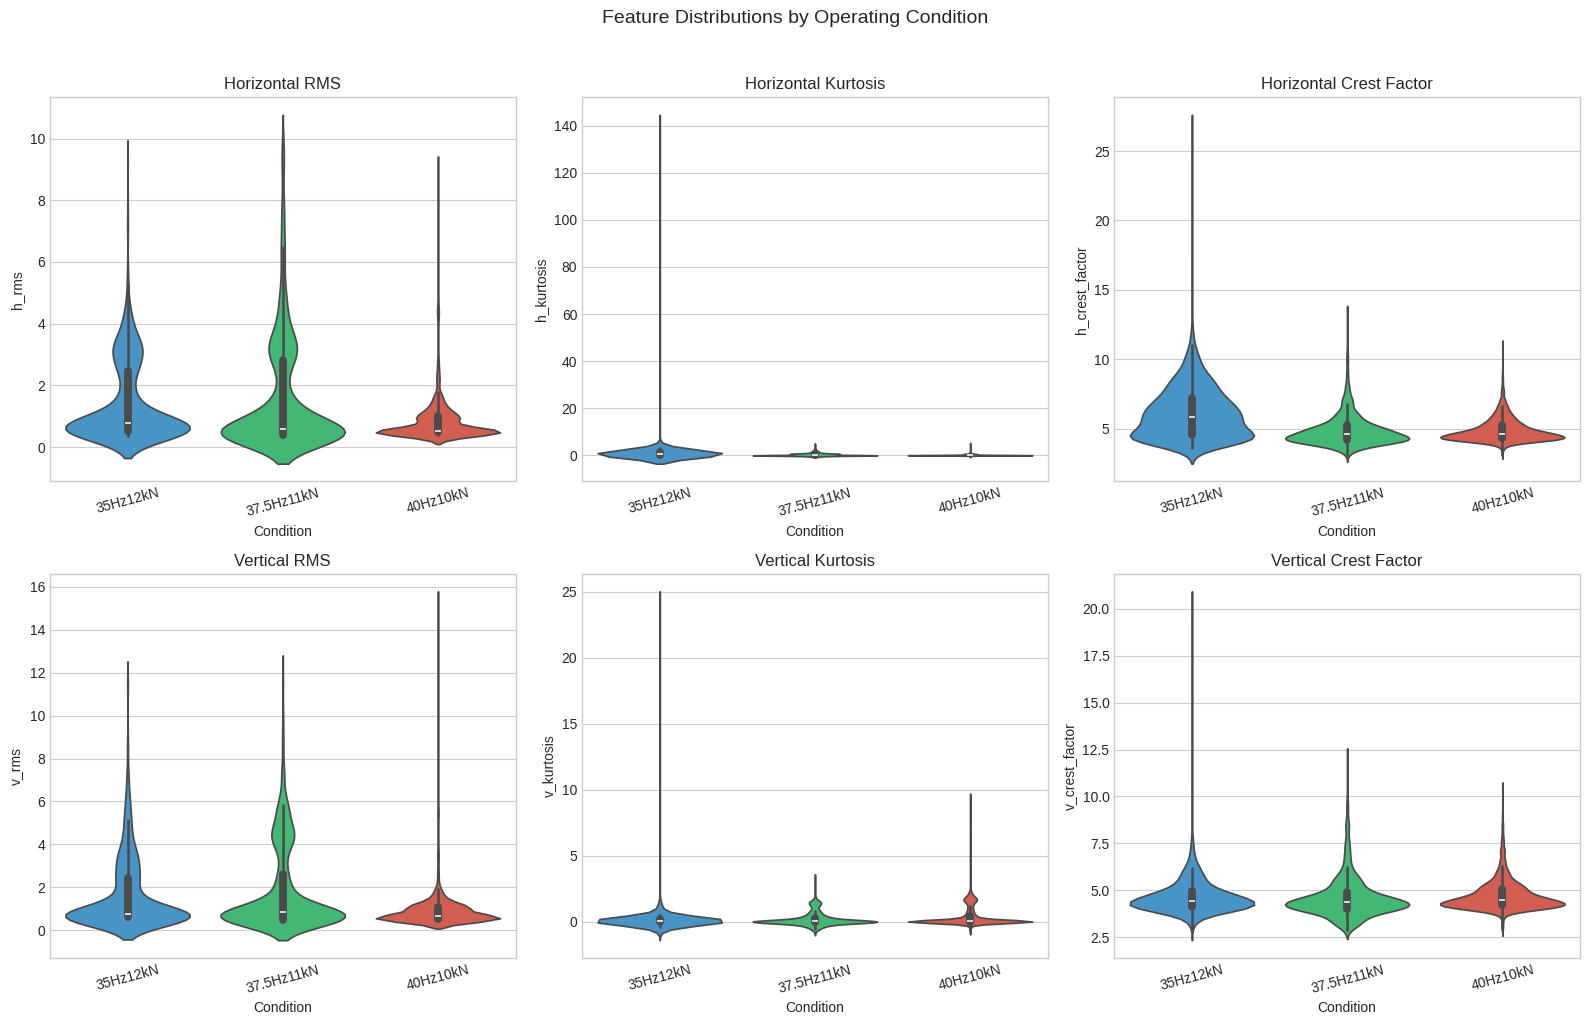

In [9]:
# Violin plots for better distribution visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

features_to_plot = ['h_rms', 'h_kurtosis', 'h_crest_factor', 
                    'v_rms', 'v_kurtosis', 'v_crest_factor']
titles = ['Horizontal RMS', 'Horizontal Kurtosis', 'Horizontal Crest Factor',
          'Vertical RMS', 'Vertical Kurtosis', 'Vertical Crest Factor']

for idx, (feat, title) in enumerate(zip(features_to_plot, titles)):
    ax = axes[idx // 3, idx % 3]
    sns.violinplot(data=df, x='condition', y=feat, ax=ax, palette=colors)
    ax.set_title(title)
    ax.set_xlabel('Condition')
    ax.tick_params(axis='x', rotation=15)

plt.suptitle('Feature Distributions by Operating Condition', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Feature Distributions Across Bearings

Examine how features vary across individual bearings to identify outliers and understand inter-bearing variability.

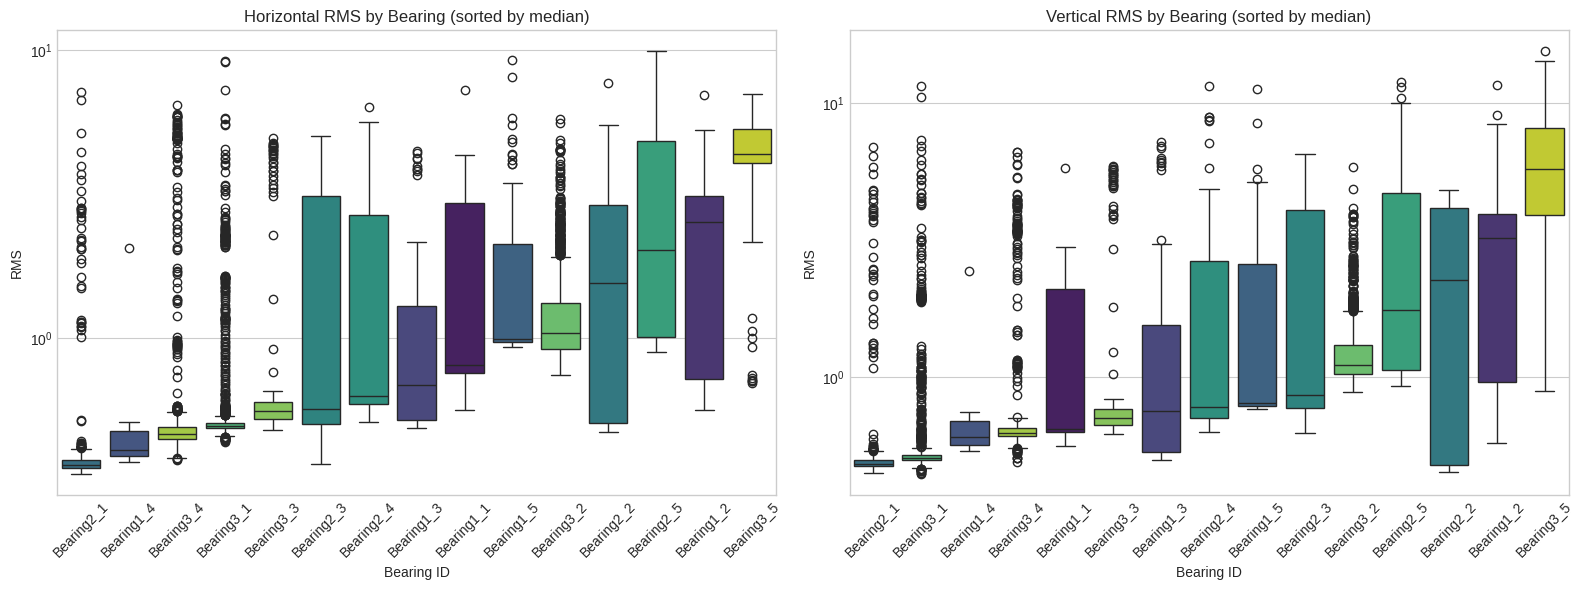

In [26]:
# RMS by bearing
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Horizontal RMS
ax = axes[0]
bearing_order = df.groupby('bearing_id')['h_rms'].median().sort_values().index
sns.boxplot(data=df, x='bearing_id', y='h_rms', order=bearing_order, ax=ax, palette='viridis', hue='bearing_id')
ax.set_title('Horizontal RMS by Bearing (sorted by median)')
ax.set_xlabel('Bearing ID')
ax.set_ylabel('RMS')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)

# Vertical RMS
ax = axes[1]
bearing_order = df.groupby('bearing_id')['v_rms'].median().sort_values().index
sns.boxplot(data=df, x='bearing_id', y='v_rms', order=bearing_order, ax=ax, palette='viridis', hue='bearing_id')
ax.set_title('Vertical RMS by Bearing (sorted by median)')
ax.set_xlabel('Bearing ID')
ax.set_ylabel('RMS')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_343828/4159132092.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='bearing_id', y='h_kurtosis', order=bearing_order, ax=ax, palette='magma', log_scale=True)
/tmp/ipykernel_343828/4159132092.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='bearing_id', y='v_kurtosis', order=bearing_order, ax=ax, palette='magma', log_scale=True)


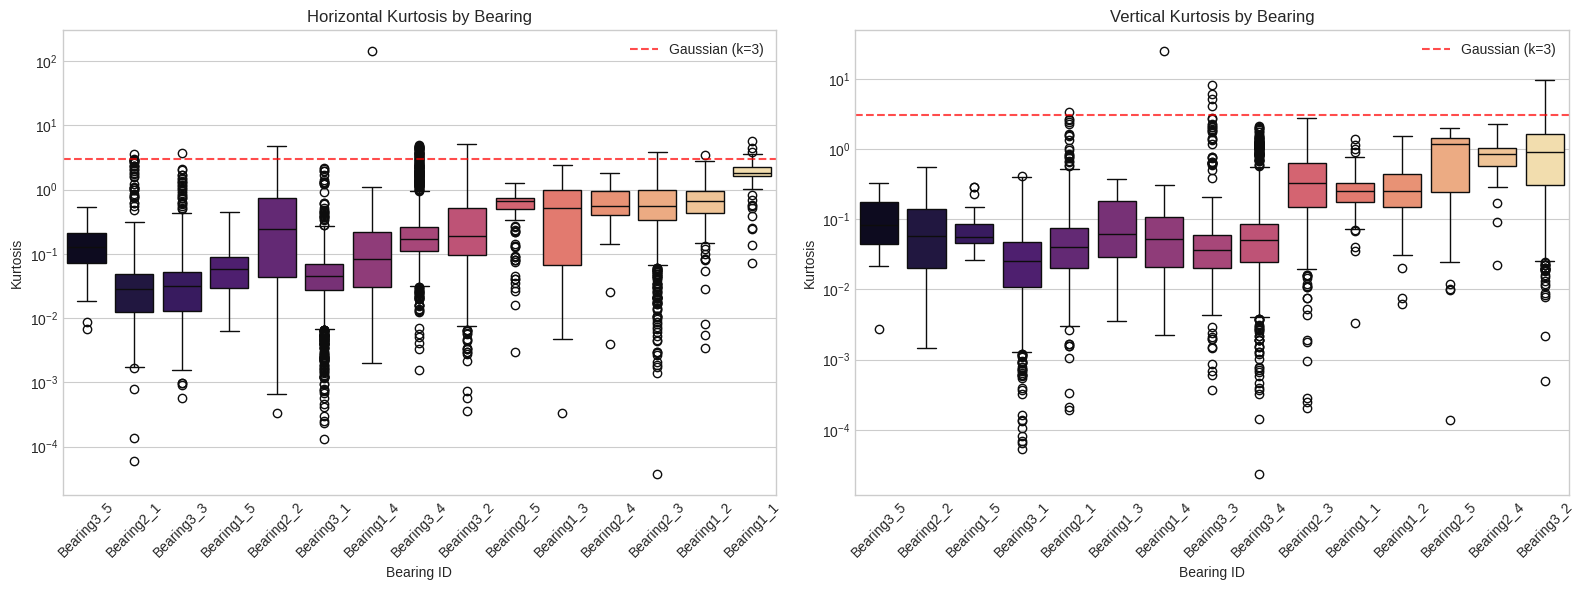

In [11]:
# Kurtosis by bearing - important degradation indicator
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Horizontal Kurtosis
ax = axes[0]
bearing_order = df.groupby('bearing_id')['h_kurtosis'].median().sort_values().index
sns.boxplot(data=df, x='bearing_id', y='h_kurtosis', order=bearing_order, ax=ax, palette='magma', log_scale=True)
ax.set_title('Horizontal Kurtosis by Bearing')
ax.set_xlabel('Bearing ID')
ax.set_ylabel('Kurtosis')
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=3, color='red', linestyle='--', alpha=0.7, label='Gaussian (k=3)')
ax.legend()

# Vertical Kurtosis
ax = axes[1]
bearing_order = df.groupby('bearing_id')['v_kurtosis'].median().sort_values().index
sns.boxplot(data=df, x='bearing_id', y='v_kurtosis', order=bearing_order, ax=ax, palette='magma', log_scale=True)
ax.set_title('Vertical Kurtosis by Bearing')
ax.set_xlabel('Bearing ID')
ax.set_ylabel('Kurtosis')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=3, color='red', linestyle='--', alpha=0.7, label='Gaussian (k=3)')
ax.legend()

plt.tight_layout()
plt.show()

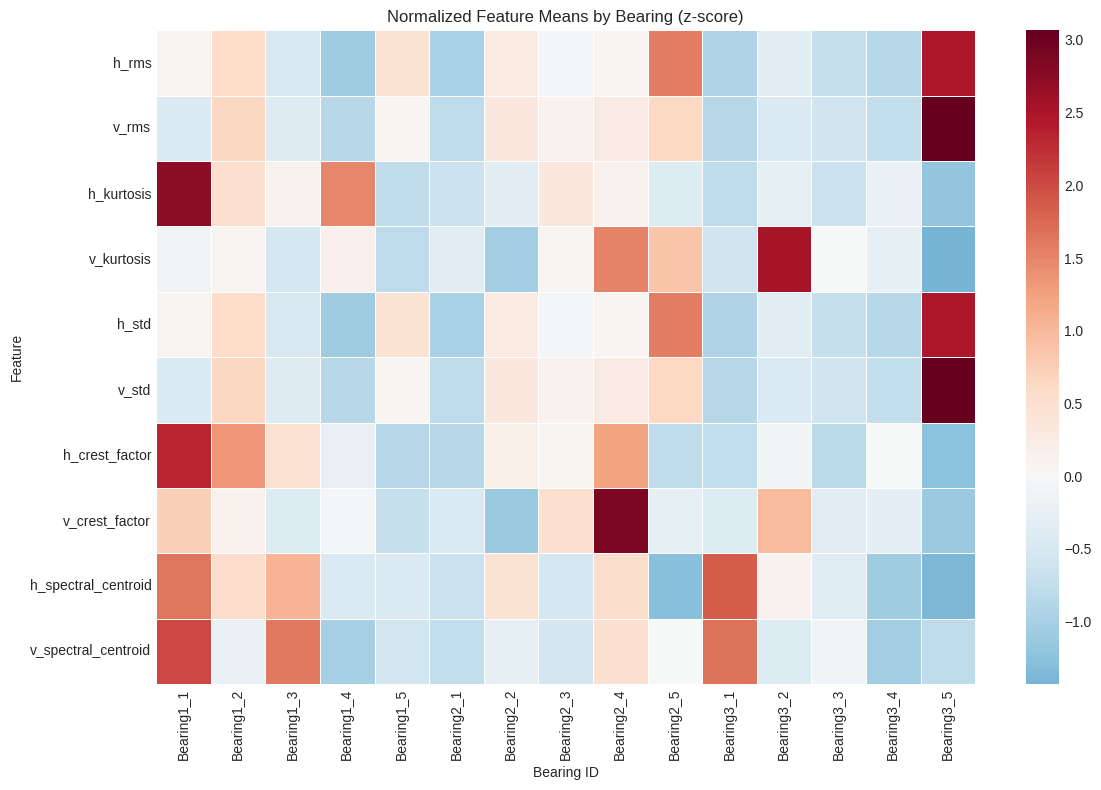

In [12]:
# Heatmap of mean features by bearing
bearing_means = df.groupby('bearing_id')[key_features].mean()

# Normalize for visualization
bearing_means_norm = (bearing_means - bearing_means.mean()) / bearing_means.std()

plt.figure(figsize=(12, 8))
sns.heatmap(bearing_means_norm.T, cmap='RdBu_r', center=0, 
            annot=False, fmt='.2f', linewidths=0.5)
plt.title('Normalized Feature Means by Bearing (z-score)')
plt.xlabel('Bearing ID')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 4. Horizontal vs Vertical Channel Comparison

Compare features between horizontal and vertical vibration channels to understand measurement characteristics.

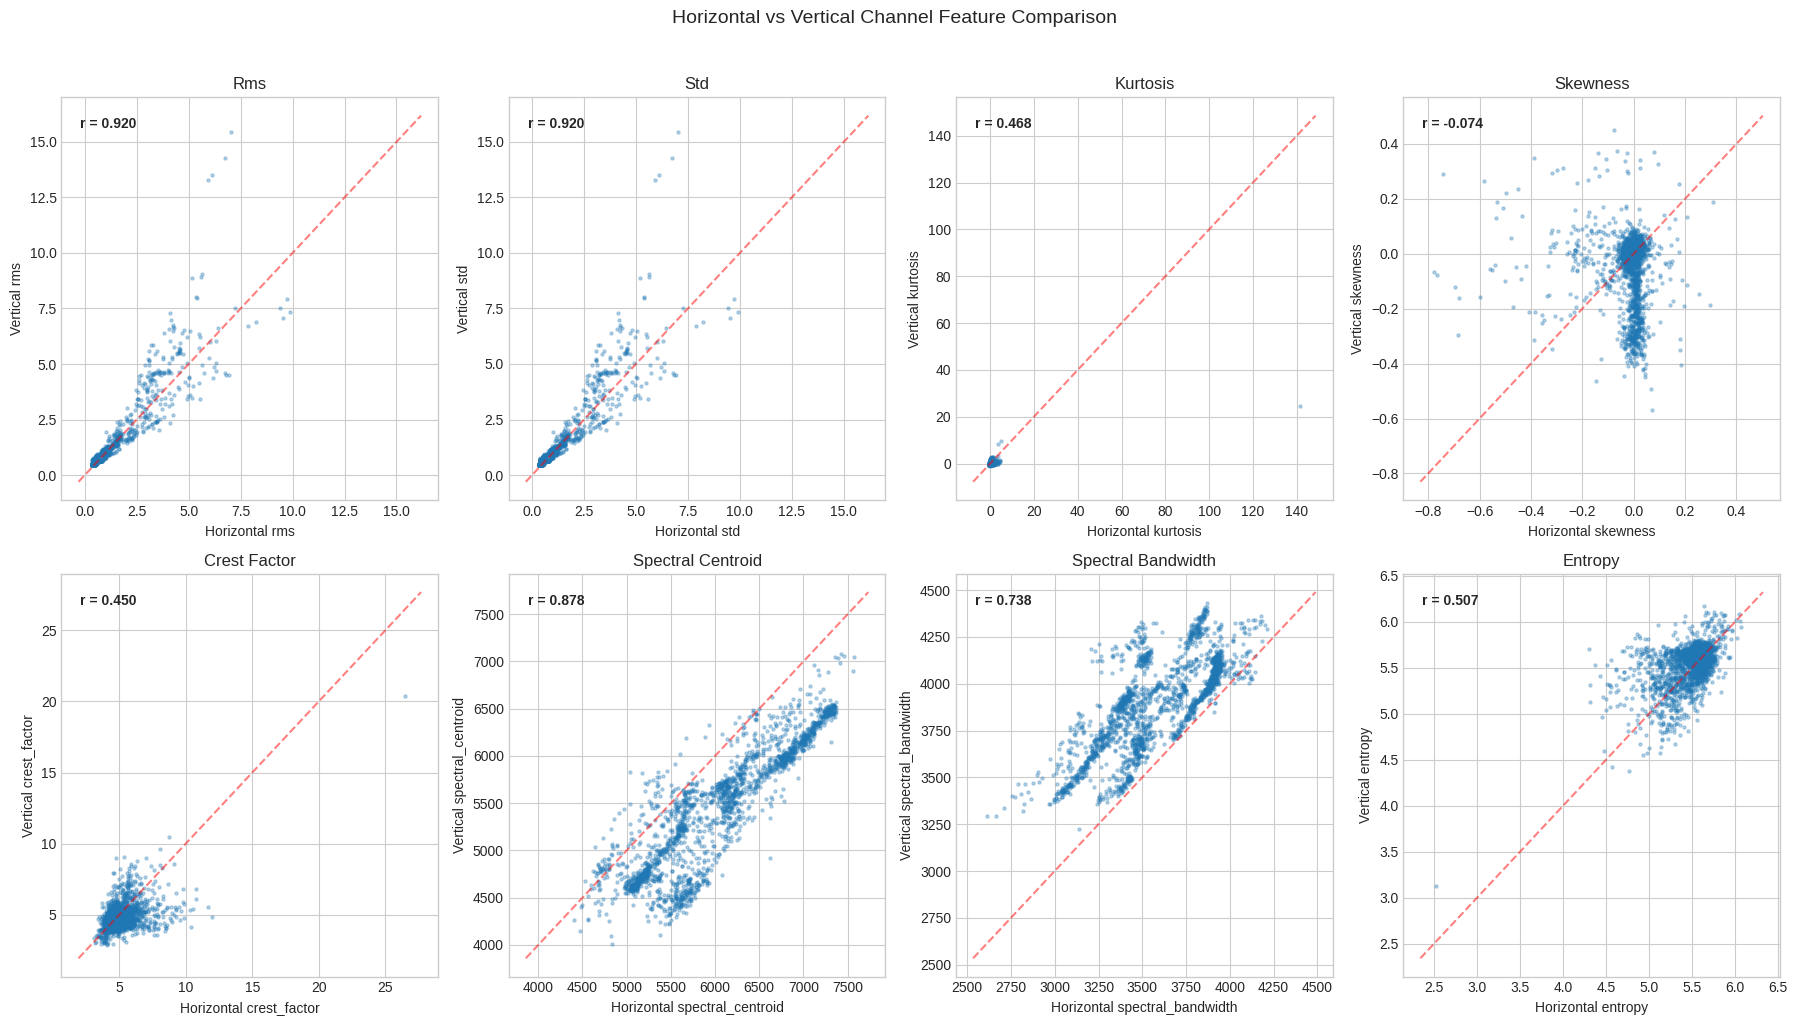

In [13]:
# Channel comparison for key features
channel_features = ['rms', 'std', 'kurtosis', 'skewness', 'crest_factor', 
                    'spectral_centroid', 'spectral_bandwidth', 'entropy']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for idx, feat in enumerate(channel_features):
    ax = axes[idx // 4, idx % 4]
    h_col = f'h_{feat}'
    v_col = f'v_{feat}'
    
    # Sample for scatter (full data too dense)
    sample = df.sample(min(2000, len(df)), random_state=42)
    
    ax.scatter(sample[h_col], sample[v_col], alpha=0.3, s=5)
    
    # Add diagonal reference line
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
            max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'r--', alpha=0.5, label='y=x')
    
    ax.set_xlabel(f'Horizontal {feat}')
    ax.set_ylabel(f'Vertical {feat}')
    ax.set_title(f'{feat.replace("_", " ").title()}')
    
    # Add correlation
    corr = df[h_col].corr(df[v_col])
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', fontweight='bold')

plt.suptitle('Horizontal vs Vertical Channel Feature Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


Horizontal/Vertical Channel Ratios:
               mean      std       min        max
rms           0.901    0.163     0.440      1.804
std           0.900    0.163     0.440      1.805
kurtosis      2.500  200.168 -1467.363  18730.779
crest_factor  1.070    0.213     0.493      2.700
entropy       0.989    0.043     0.751      1.205


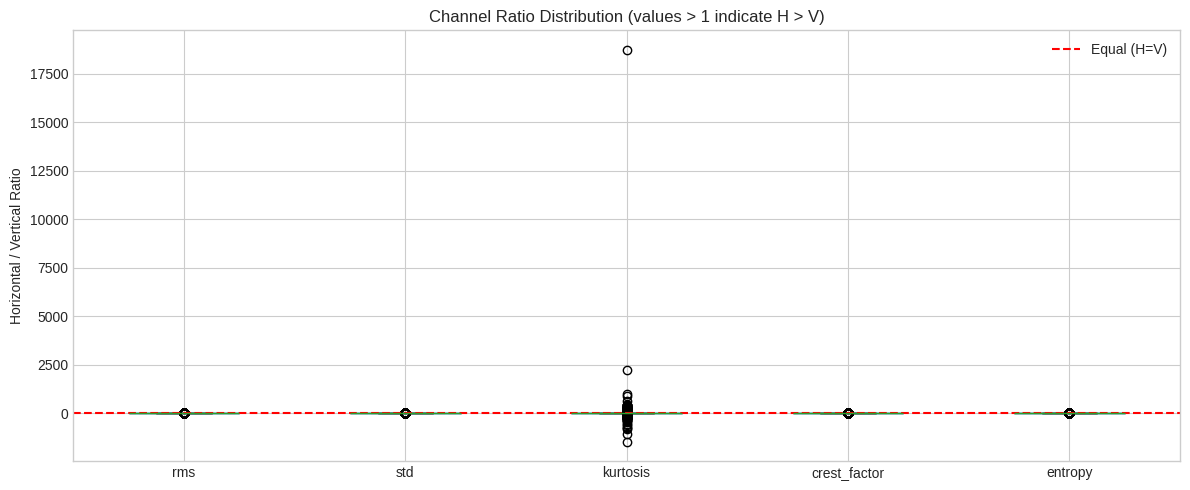

In [14]:
# Channel ratio analysis
print("\nHorizontal/Vertical Channel Ratios:")
print("=" * 60)

ratios = pd.DataFrame()
for feat in ['rms', 'std', 'kurtosis', 'crest_factor', 'entropy']:
    h_col = f'h_{feat}'
    v_col = f'v_{feat}'
    # Avoid division by zero
    ratio = df[h_col] / (df[v_col] + 1e-10)
    ratios[feat] = ratio

print(ratios.describe().T[['mean', 'std', 'min', 'max']].round(3))

# Box plot of ratios
fig, ax = plt.subplots(figsize=(12, 5))
ratios.boxplot(ax=ax)
ax.axhline(y=1, color='red', linestyle='--', label='Equal (H=V)')
ax.set_ylabel('Horizontal / Vertical Ratio')
ax.set_title('Channel Ratio Distribution (values > 1 indicate H > V)')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Cross-Channel Correlation Analysis

Analyze the correlation between horizontal and vertical channels, and how it changes with degradation.

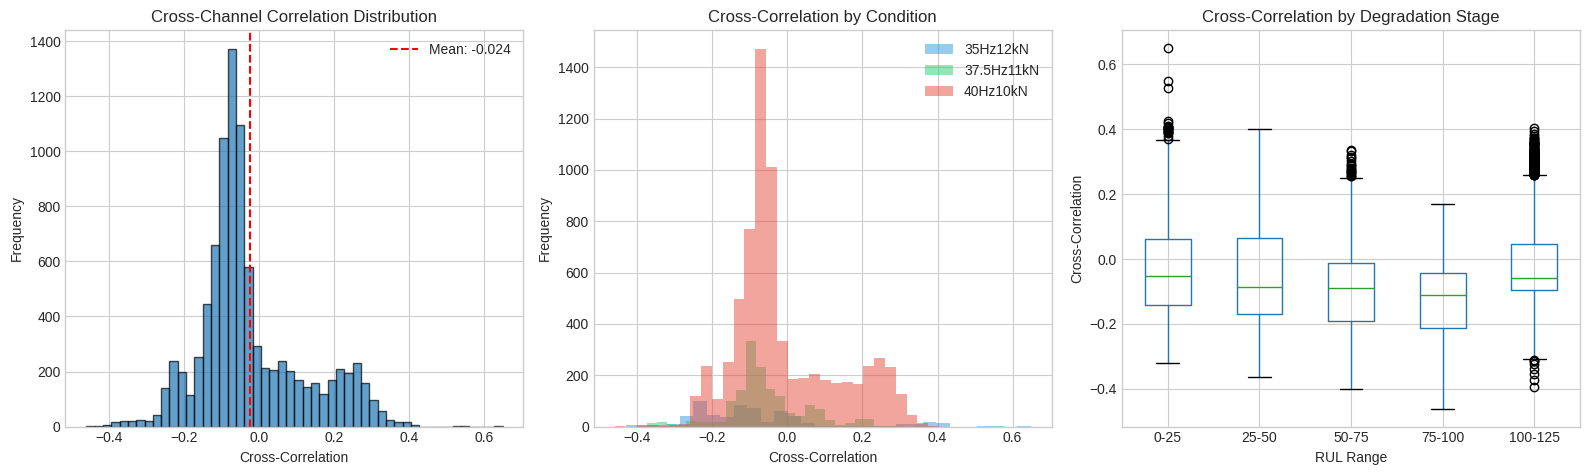

In [15]:
# Cross-correlation feature distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Overall distribution
ax = axes[0]
ax.hist(df['cross_correlation'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(df['cross_correlation'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["cross_correlation"].mean():.3f}')
ax.set_xlabel('Cross-Correlation')
ax.set_ylabel('Frequency')
ax.set_title('Cross-Channel Correlation Distribution')
ax.legend()

# By condition
ax = axes[1]
for cond, color in zip(conditions, colors):
    data = df[df['condition'] == cond]['cross_correlation']
    ax.hist(data, bins=30, alpha=0.5, label=cond, color=color)
ax.set_xlabel('Cross-Correlation')
ax.set_ylabel('Frequency')
ax.set_title('Cross-Correlation by Condition')
ax.legend()

# By RUL (degradation stage)
ax = axes[2]
df['rul_bin'] = pd.cut(df['rul'], bins=[0, 25, 50, 75, 100, 125], 
                       labels=['0-25', '25-50', '50-75', '75-100', '100-125'])
df.boxplot(column='cross_correlation', by='rul_bin', ax=ax)
ax.set_xlabel('RUL Range')
ax.set_ylabel('Cross-Correlation')
ax.set_title('Cross-Correlation by Degradation Stage')
plt.suptitle('')

plt.tight_layout()
plt.show()

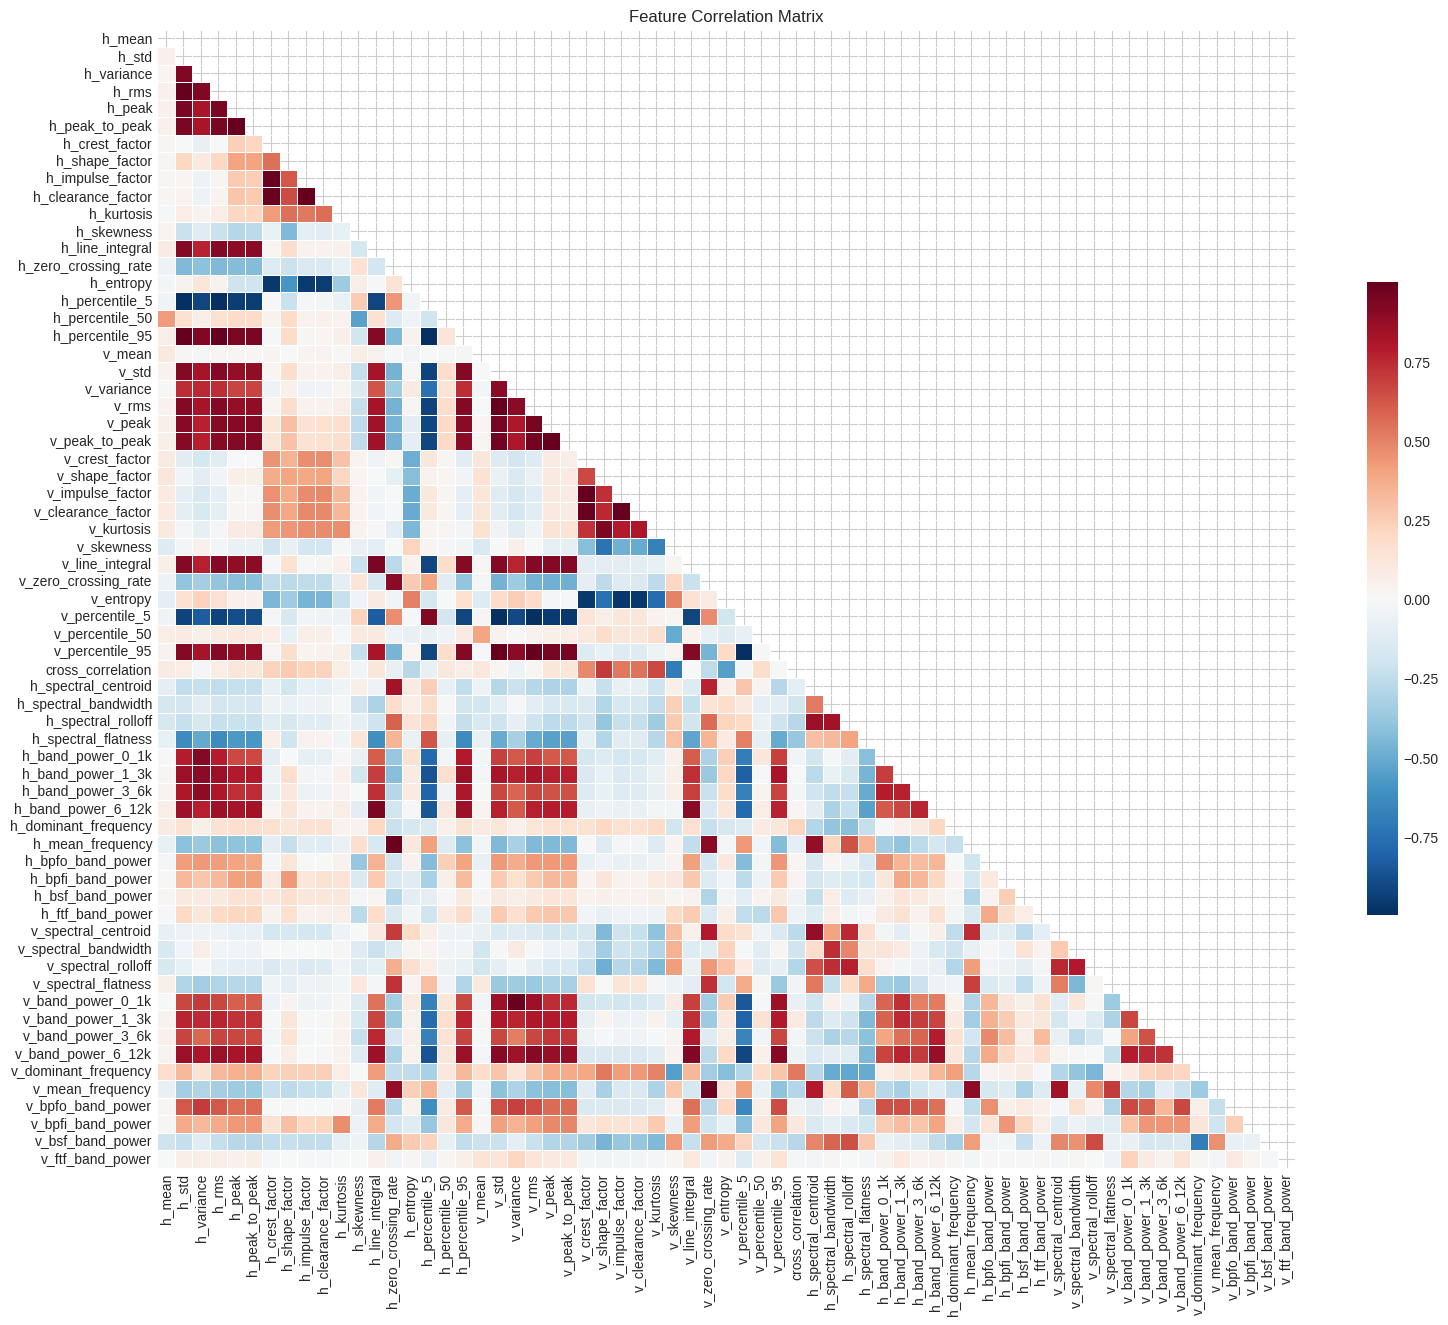

In [16]:
# Feature correlation matrix
feature_cols = [c for c in df.columns if c.startswith(('h_', 'v_')) or c == 'cross_correlation']
corr_matrix = df[feature_cols].corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

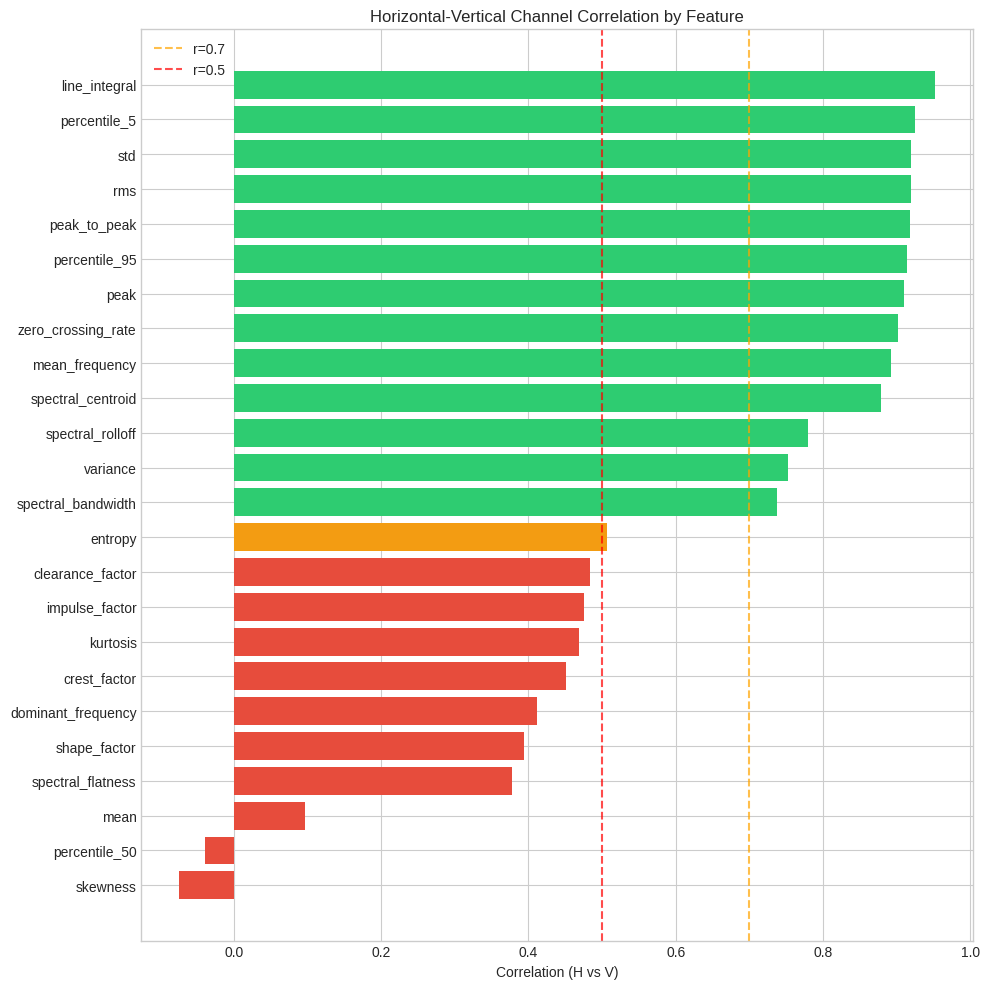

In [17]:
# Correlation between corresponding H and V features
h_v_correlations = {}
for feat in ['mean', 'std', 'variance', 'rms', 'peak', 'peak_to_peak', 'crest_factor',
             'shape_factor', 'impulse_factor', 'clearance_factor', 'kurtosis', 'skewness',
             'line_integral', 'zero_crossing_rate', 'entropy', 'percentile_5', 'percentile_50',
             'percentile_95', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff',
             'spectral_flatness', 'dominant_frequency', 'mean_frequency']:
    h_col = f'h_{feat}'
    v_col = f'v_{feat}'
    if h_col in df.columns and v_col in df.columns:
        h_v_correlations[feat] = df[h_col].corr(df[v_col])

# Plot correlations
corr_df = pd.DataFrame.from_dict(h_v_correlations, orient='index', columns=['correlation'])
corr_df = corr_df.sort_values('correlation', ascending=True)

plt.figure(figsize=(10, 10))
colors_bar = ['#e74c3c' if c < 0.5 else '#f39c12' if c < 0.7 else '#2ecc71' 
              for c in corr_df['correlation']]
plt.barh(corr_df.index, corr_df['correlation'], color=colors_bar)
plt.axvline(x=0.7, color='orange', linestyle='--', alpha=0.7, label='r=0.7')
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='r=0.5')
plt.xlabel('Correlation (H vs V)')
plt.title('Horizontal-Vertical Channel Correlation by Feature')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Degradation Progression Analysis

Track how RMS and kurtosis evolve over the bearing lifecycle to visualize degradation patterns.

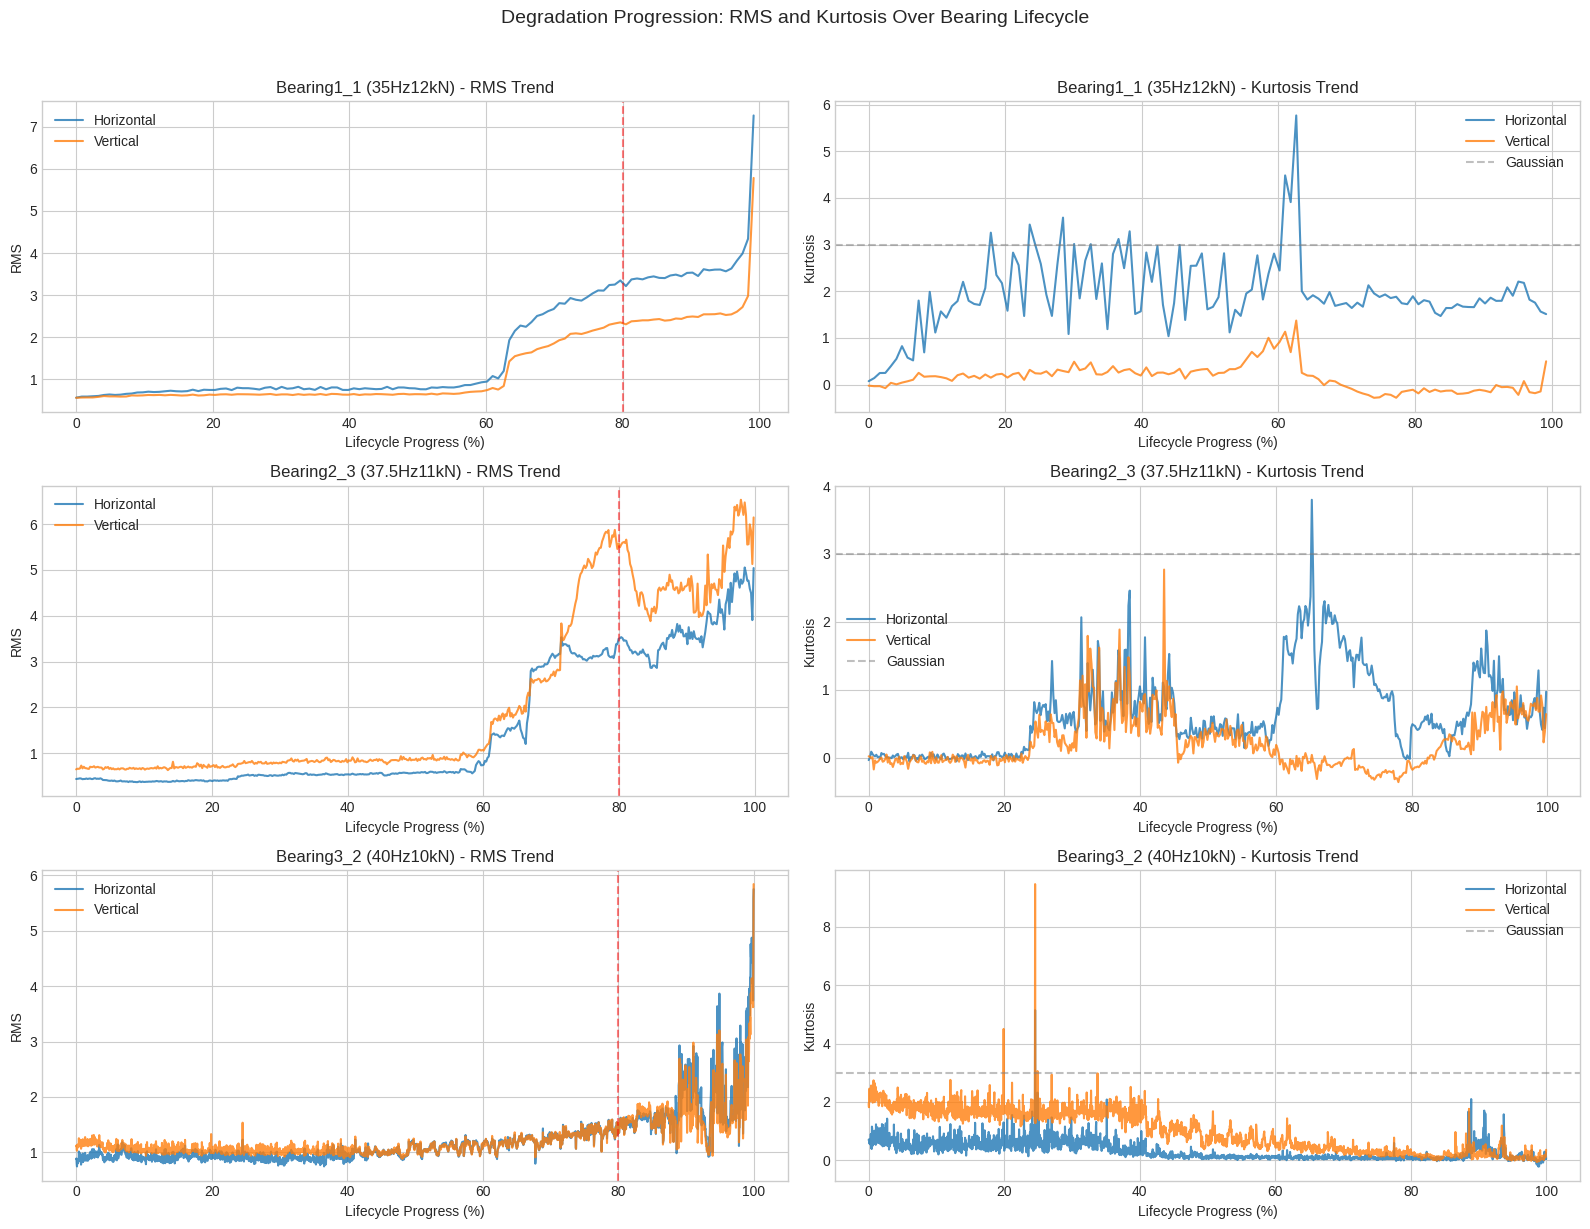

In [18]:
# Select bearings for degradation visualization
# Choose one from each condition with sufficient lifecycle data
sample_bearings = [
    ('35Hz12kN', 'Bearing1_1'),
    ('37.5Hz11kN', 'Bearing2_3'),
    ('40Hz10kN', 'Bearing3_2'),
]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for idx, (cond, bearing) in enumerate(sample_bearings):
    bearing_data = df[(df['condition'] == cond) & (df['bearing_id'] == bearing)].sort_values('file_idx')
    lifecycle_pct = bearing_data['file_idx'] / bearing_data['total_files'].iloc[0] * 100
    
    # RMS trend
    ax = axes[idx, 0]
    ax.plot(lifecycle_pct, bearing_data['h_rms'], label='Horizontal', alpha=0.8)
    ax.plot(lifecycle_pct, bearing_data['v_rms'], label='Vertical', alpha=0.8)
    ax.set_xlabel('Lifecycle Progress (%)')
    ax.set_ylabel('RMS')
    ax.set_title(f'{bearing} ({cond}) - RMS Trend')
    ax.legend()
    ax.axvline(x=80, color='red', linestyle='--', alpha=0.5, label='80% life')
    
    # Kurtosis trend
    ax = axes[idx, 1]
    ax.plot(lifecycle_pct, bearing_data['h_kurtosis'], label='Horizontal', alpha=0.8)
    ax.plot(lifecycle_pct, bearing_data['v_kurtosis'], label='Vertical', alpha=0.8)
    ax.set_xlabel('Lifecycle Progress (%)')
    ax.set_ylabel('Kurtosis')
    ax.set_title(f'{bearing} ({cond}) - Kurtosis Trend')
    ax.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Gaussian')
    ax.legend()

plt.suptitle('Degradation Progression: RMS and Kurtosis Over Bearing Lifecycle', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

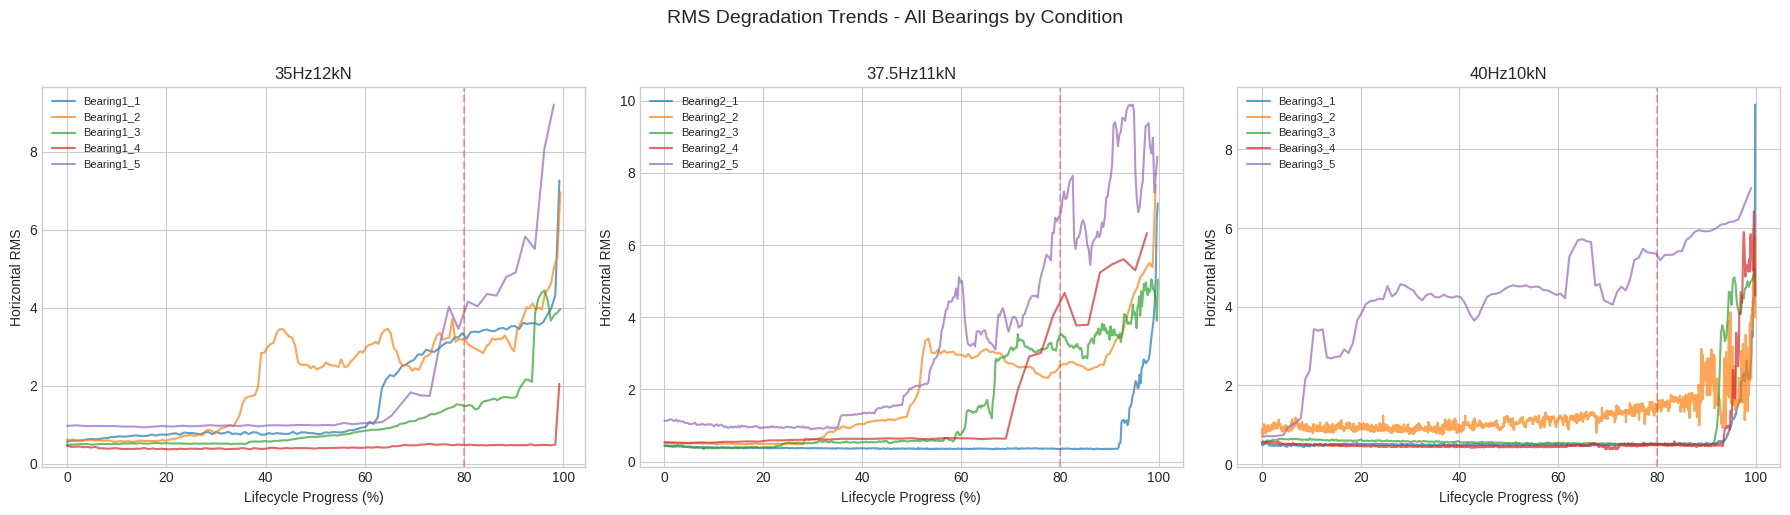

In [19]:
# All bearings RMS progression (normalized lifecycle)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, cond in enumerate(conditions):
    ax = axes[idx]
    cond_bearings = df[df['condition'] == cond]['bearing_id'].unique()
    
    for bearing in cond_bearings:
        bearing_data = df[(df['condition'] == cond) & (df['bearing_id'] == bearing)].sort_values('file_idx')
        lifecycle_pct = bearing_data['file_idx'] / bearing_data['total_files'].iloc[0] * 100
        ax.plot(lifecycle_pct, bearing_data['h_rms'], label=bearing, alpha=0.7)
    
    ax.set_xlabel('Lifecycle Progress (%)')
    ax.set_ylabel('Horizontal RMS')
    ax.set_title(f'{cond}')
    ax.legend(fontsize=8)
    ax.axvline(x=80, color='red', linestyle='--', alpha=0.3)

plt.suptitle('RMS Degradation Trends - All Bearings by Condition', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

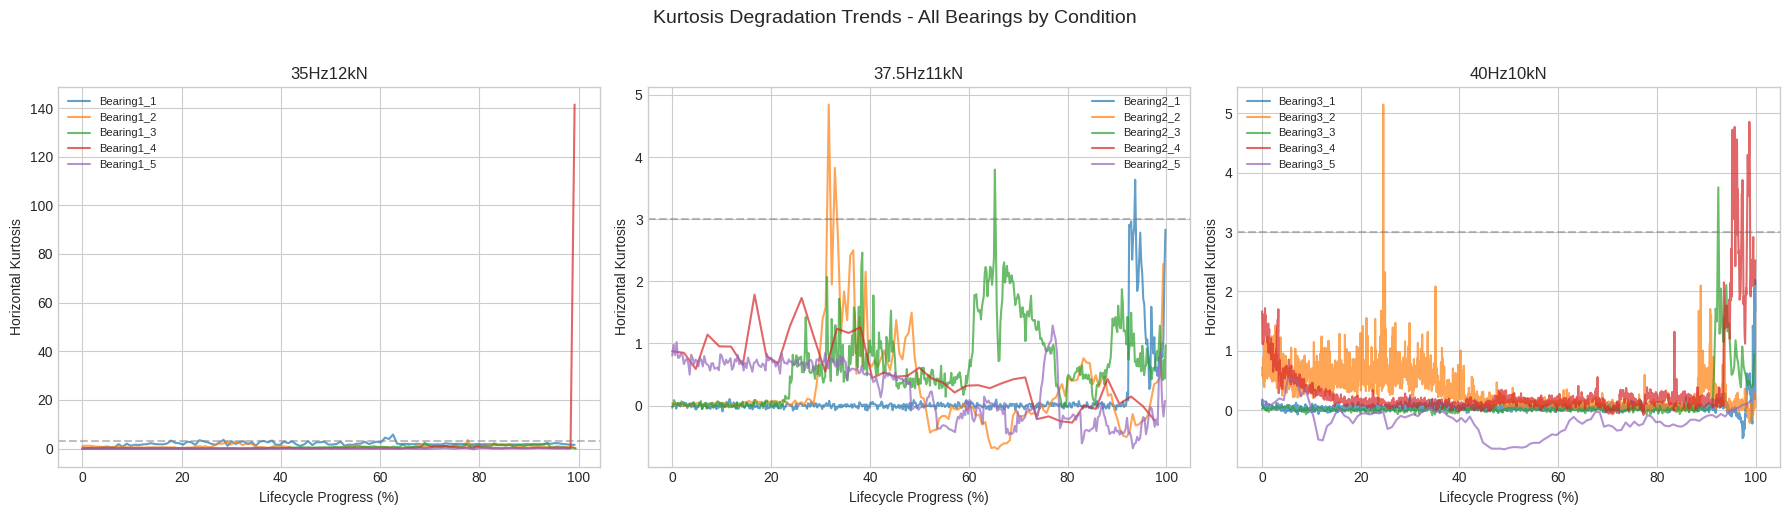

In [20]:
# Kurtosis progression for all bearings
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, cond in enumerate(conditions):
    ax = axes[idx]
    cond_bearings = df[df['condition'] == cond]['bearing_id'].unique()
    
    for bearing in cond_bearings:
        bearing_data = df[(df['condition'] == cond) & (df['bearing_id'] == bearing)].sort_values('file_idx')
        lifecycle_pct = bearing_data['file_idx'] / bearing_data['total_files'].iloc[0] * 100
        ax.plot(lifecycle_pct, bearing_data['h_kurtosis'], label=bearing, alpha=0.7)
    
    ax.set_xlabel('Lifecycle Progress (%)')
    ax.set_ylabel('Horizontal Kurtosis')
    ax.set_title(f'{cond}')
    ax.legend(fontsize=8)
    ax.axhline(y=3, color='gray', linestyle='--', alpha=0.5)

plt.suptitle('Kurtosis Degradation Trends - All Bearings by Condition', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

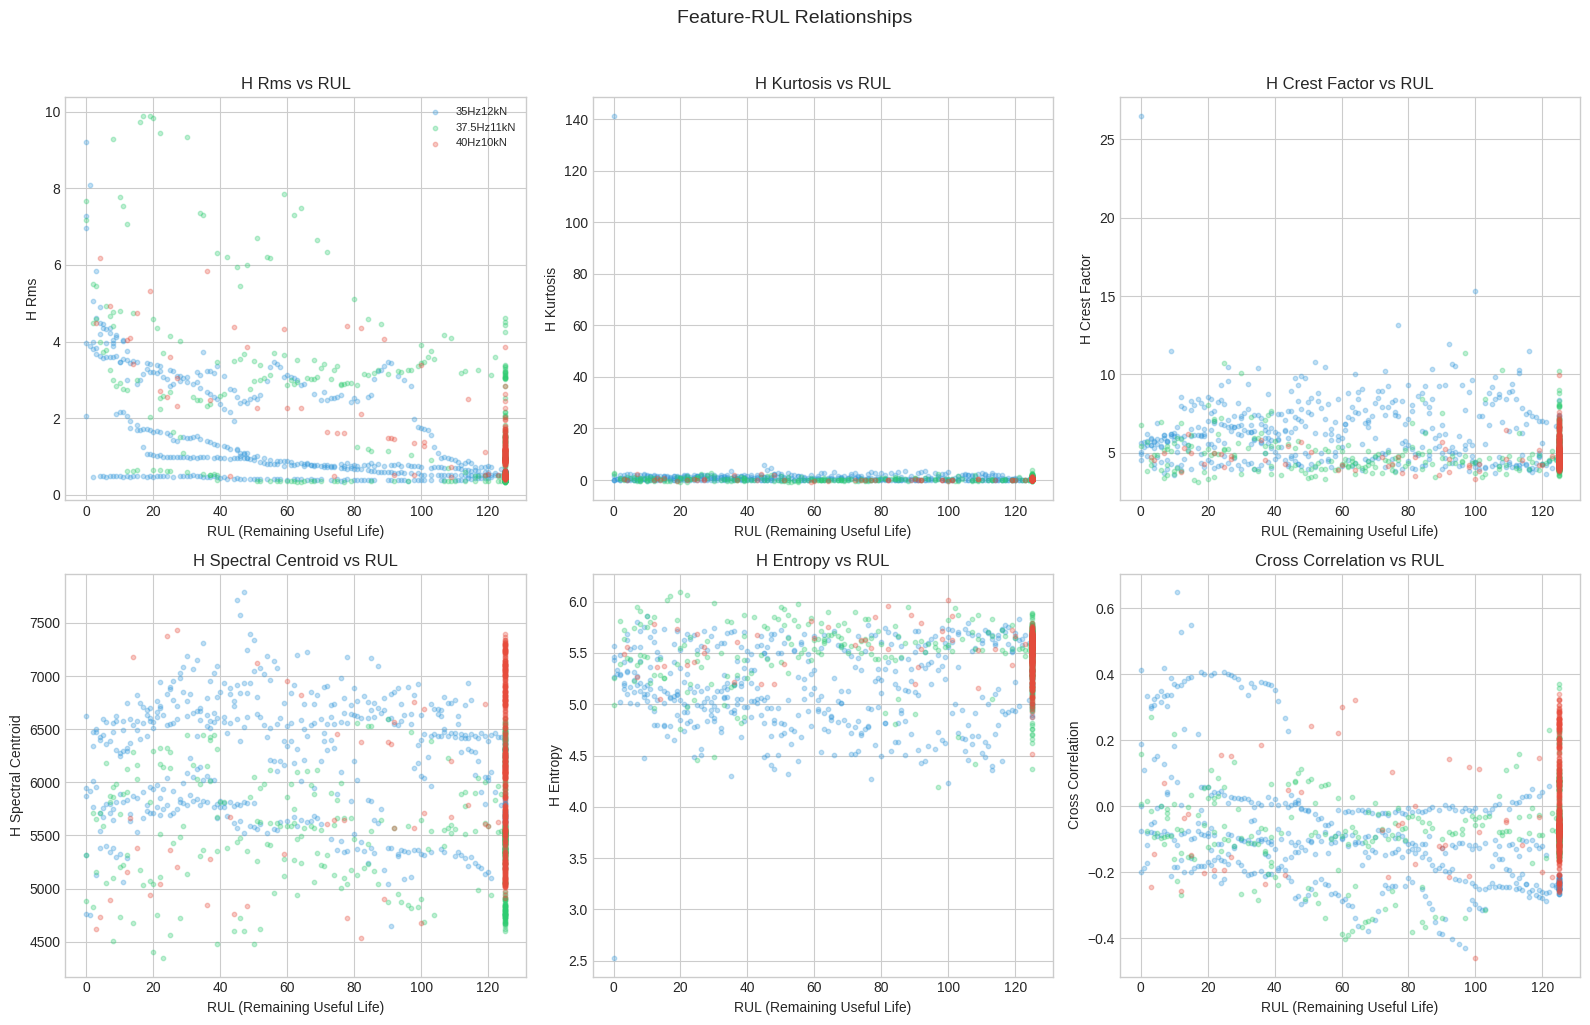

In [21]:
# Feature vs RUL scatter plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

features_rul = ['h_rms', 'h_kurtosis', 'h_crest_factor', 
                'h_spectral_centroid', 'h_entropy', 'cross_correlation']

for idx, feat in enumerate(features_rul):
    ax = axes[idx // 3, idx % 3]
    
    for cond, color in zip(conditions, colors):
        cond_data = df[df['condition'] == cond].sample(min(500, len(df[df['condition'] == cond])), random_state=42)
        ax.scatter(cond_data['rul'], cond_data[feat], alpha=0.3, s=10, c=color, label=cond)
    
    ax.set_xlabel('RUL (Remaining Useful Life)')
    ax.set_ylabel(feat.replace('_', ' ').title())
    ax.set_title(f'{feat.replace("_", " ").title()} vs RUL')
    if idx == 0:
        ax.legend(fontsize=8)

plt.suptitle('Feature-RUL Relationships', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. Summary Statistics and Key Findings

In [22]:
# Overall dataset statistics
print("=" * 70)
print("STATISTICAL EDA SUMMARY")
print("=" * 70)

print("\n1. DATASET IMBALANCE")
print("-" * 50)
for cond in conditions:
    count = len(df[df['condition'] == cond])
    pct = count / len(df) * 100
    print(f"   {cond}: {count:,} samples ({pct:.1f}%)")

print("\n2. FEATURE RANGES (Overall)")
print("-" * 50)
summary_features = ['h_rms', 'v_rms', 'h_kurtosis', 'v_kurtosis', 'h_crest_factor', 'cross_correlation']
print(df[summary_features].describe().T[['mean', 'std', 'min', 'max']].round(4).to_string())

print("\n3. CHANNEL COMPARISON")
print("-" * 50)
print(f"   Mean H/V RMS ratio: {(df['h_rms'] / df['v_rms']).mean():.3f}")
print(f"   Mean cross-correlation: {df['cross_correlation'].mean():.3f}")
print(f"   H-V RMS correlation: {df['h_rms'].corr(df['v_rms']):.3f}")

print("\n4. RUL DISTRIBUTION")
print("-" * 50)
print(f"   RUL range: {df['rul'].min():.0f} - {df['rul'].max():.0f}")
print(f"   Mean RUL: {df['rul'].mean():.1f}")
print(f"   Median RUL: {df['rul'].median():.1f}")

STATISTICAL EDA SUMMARY

1. DATASET IMBALANCE
--------------------------------------------------
   35Hz12kN: 616 samples (6.7%)
   37.5Hz11kN: 1,566 samples (17.0%)
   40Hz10kN: 7,034 samples (76.3%)

2. FEATURE RANGES (Overall)
--------------------------------------------------
                     mean     std     min       max
h_rms              1.0609  1.1581  0.3381    9.8944
v_rms              1.1838  1.3656  0.4445   15.4317
h_kurtosis         0.2892  1.5569 -0.7058  141.4375
v_kurtosis         0.3321  0.6832 -0.8323   24.4573
h_crest_factor     4.9739  1.0572  3.1062   26.5173
cross_correlation -0.0243  0.1403 -0.4603    0.6486

3. CHANNEL COMPARISON
--------------------------------------------------
   Mean H/V RMS ratio: 0.901
   Mean cross-correlation: -0.024
   H-V RMS correlation: 0.920

4. RUL DISTRIBUTION
--------------------------------------------------
   RUL range: 0 - 125
   Mean RUL: 112.9
   Median RUL: 125.0


In [23]:
# Feature correlation with RUL
print("\n5. FEATURE-RUL CORRELATIONS (Top 10 by absolute value)")
print("-" * 50)

feature_cols = [c for c in df.columns if c.startswith(('h_', 'v_')) or c == 'cross_correlation']
rul_correlations = df[feature_cols + ['rul']].corr()['rul'].drop('rul').abs().sort_values(ascending=False)

for feat, corr in rul_correlations.head(10).items():
    sign = '+' if df[feat].corr(df['rul']) > 0 else '-'
    print(f"   {feat}: {sign}{corr:.3f}")


5. FEATURE-RUL CORRELATIONS (Top 10 by absolute value)
--------------------------------------------------
   h_peak_to_peak: -0.704
   h_peak: -0.704
   v_percentile_5: +0.677
   v_peak_to_peak: -0.677
   v_rms: -0.673
   v_std: -0.673
   v_peak: -0.672
   h_percentile_5: +0.669
   h_rms: -0.669
   h_std: -0.669


## Key Findings

### Dataset Imbalance
- The 40Hz/10kN condition contains ~76% of all samples due to longer bearing run times
- This imbalance should be addressed during model training (stratified sampling, class weights)

### Channel Characteristics
- Horizontal and vertical channels show moderate to high correlation for most features
- Some features (spectral centroid, dominant frequency) have lower H-V correlation, suggesting complementary information
- Mean H/V RMS ratio varies by condition, indicating different loading patterns

### Degradation Indicators
- RMS shows clear increasing trend toward end-of-life for most bearings
- Kurtosis exhibits more complex patterns with spikes indicating impact events
- Spectral features evolve as degradation progresses

### Recommendations for Modeling
1. Use both channels - they provide complementary information
2. Address imbalance with stratified cross-validation by condition
3. RMS, kurtosis, and crest factor are strong degradation indicators
4. Consider condition-specific normalization or separate models per condition

In [24]:
# Cleanup temporary column
if 'rul_bin' in df.columns:
    df = df.drop(columns=['rul_bin'])

print("EDA-1 Statistical Analysis Complete!")

EDA-1 Statistical Analysis Complete!
